In [1]:
!date

Fri May  2 11:32:12 AM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
import ants
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm

In [4]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [5]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n = len(subs)
n = 14
n

14

In [6]:
a = os.listdir('../Data/StudyForrest/ensembles_last_CVAE/')
a.sort()
a

['.ipynb_checkpoints',
 'BrainIAK-CVAE-0',
 'BrainIAK-CVAE-1',
 'DeNN-forrest-v1',
 'DeepCor-ABCD-v1',
 'DeepCor-ABCD-v2',
 'DeepCor-ABCD-v3',
 'DeepCor-Forrest-ablations-00-baseline',
 'DeepCor-Forrest-ablations-01-nosummation',
 'DeepCor-Forrest-ablations-02-noAdvRemoval',
 'DeepCor-Forrest-ablations-03-noNCC',
 'DeepCor-Forrest-ablations-03-noTC',
 'DeepCor-Forrest-ablations-04-noCoords',
 'DeepCor-Forrest-ablations-06-noAll',
 'DeepCor-Forrest-ablations-06-noAll-v2',
 'DeepCor-Forrest-face-big-16',
 'DeepCor-Forrest-face-long',
 'DeepCor-Forrest-face-v1',
 'YuOrig-00-DataloaderFix',
 'YuOrig-00-orig',
 'fixed-seed-00-YuOrig-00-DataloaderFix',
 'fixed-seed-00-baseline-00',
 'slurm_files',
 'test',
 'test-lin']

In [7]:
#analysis_name =  'DeepCor-Forrest-ablations-00-baseline'
#analysis_name =  'DeepCor-Forrest-ablations-01-nosummation'
#analysis_name =  'DeepCor-Forrest-ablations-02-noAdvRemoval'
#analysis_name =  'DeepCor-Forrest-ablations-03-noNCC'
#analysis_name =  'DeepCor-Forrest-ablations-03-noTC'
#analysis_name =  'DeepCor-Forrest-ablations-04-noCoords'
#analysis_name =  'DeepCor-Forrest-ablations-06-noAll'
#analysis_name =  'DeepCor-Forrest-ablations-06-noAll-v2'
#analysis_name =  'DeepCor-Forrest-face-v1'
analysis_name =  'DeepCor-Forrest-face-big-16'
analysis_name = 'DeepCor-Forrest-face-long'
#analysis_name =  'YuOrig-00-orig'
#analysis_name = 'fixed-seed-00-baseline-00'
analysis_dir = os.path.join('../Data/StudyForrest/ensembles_last_CVAE/',analysis_name)

In [8]:
#dict_keys(['recon', 'recon_coords', 'signal', 'signal_coords', 'noise', 'noise_coords', 'ffa', 'ffa_coords', 'ffa_compcorr', 'face_reg', 'place_reg', 'confounds'])

In [9]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
n = len(subs)
events_fn_temp = '../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'

In [10]:
def get_regs(events_fn):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = 2.0 
    #n_scans = epi.shape[-1]
    n_scans = 156
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

    #face_reg = X1['face'].values
    #place_reg = X1[['body', 'house', 'object', 'scene', 'scramble']].values.sum(axis=1)

    #face_reg = X1[['face','body']].values.sum(axis=1)
    face_reg = X1[['face']].values.sum(axis=1)
    place_reg = X1[['house','scene']].values.sum(axis=1)
    
    return face_reg,place_reg

In [11]:
def get_sub_data(s,r,return_type='corr'):
    output_files = [os.path.join(analysis_dir,val) for val in os.listdir(analysis_dir) if val.startswith(f'outputs_S{s}_R{r}_')]
    vals_ffa = load_pickle(output_files[0])['ffa']
    vals_compcor = load_pickle(output_files[0])['ffa_compcorr']
    #face_reg = load_pickle(output_files[0])['face_reg']
    face_reg, place_reg = get_regs(events_fn_temp.format(sub=subs[s],r=r))    
    vals_signals = np.array([load_pickle(output_file)['signal'] for output_file in output_files])
    vals_signals_med = np.nanmedian(vals_signals,0)
    #vals_signals_med = np.average(vals_signals,0)

    r_ffa = np.array([np.corrcoef(vals_ffa[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    r_compcor = np.array([np.corrcoef(vals_compcor[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    r_fg = np.array([np.corrcoef(vals_signals_med[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    
    if return_type=='corr':
        return (r_ffa,r_compcor,r_fg)
    elif return_type=='vals':
        return vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg

In [12]:
do_plot_indiv = False
if do_plot_indiv==True:
    for s in range(14):
        for r in [1,2,3,4]:
            vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg = get_sub_data(s,r,return_type='vals')

            plt.figure(figsize=(25,5))
            plt.subplot(1,4,1)
            plt.plot(vals_ffa.mean(axis=0))
            plt.plot(face_reg)
            c = np.corrcoef(vals_ffa.mean(axis=0),face_reg)[0,1]
            plt.title(f'NoDenoise, r={c:.2f}')
            plt.ylim(-1.5,1.5)

            plt.subplot(1,4,2)
            plt.plot(vals_compcor.mean(axis=0))
            plt.plot(face_reg)
            c = np.corrcoef(vals_compcor.mean(axis=0),face_reg)[0,1]
            plt.title(f'CompCor, r={c:.2f}')
            plt.ylim(-1.5,1.5)

            plt.subplot(1,4,3)
            plt.plot(vals_signals_med.mean(axis=0))
            plt.plot(face_reg)
            c = np.corrcoef(vals_signals_med.mean(axis=0),face_reg)[0,1]
            plt.title(f'DeepCor, r={c:.2f}')
            plt.ylim(-1.5,1.5)

            plt.subplot(1,4,4)
            for i in range(vals_signals.shape[0]):
                plt.plot(vals_signals[i,:,:].mean(axis=0),alpha=.5)
            plt.plot(face_reg)

            plt.suptitle(f'S{s}/R{r}')

In [13]:
nsubs = n
#corr_res = np.array([[get_sub_data(s,r) for r in [1,2,3,4]] for s in range(nsubs)])
corr_res = np.array([[get_sub_data(s,r) for r in [1,2,3,4]] for s in range(nsubs)])
corr_res.shape

IndexError: list index out of range

In [28]:
ys = corr_res.mean(axis=0).mean(axis=0)
print(ys)
xs = [0,1,2]
plt.bar(xs,ys)
plt.xticks(xs,labels=['NoDenoise','CompCor','DeepCor'])

NameError: name 'corr_res' is not defined

In [63]:
corr_res.shape

(14, 4, 3)

In [87]:
def pretty_t_test(vec1,vec2,ttl,alternative='two-sided'):
    from scipy.stats import ttest_rel
    #vec1 = vec_compcor
    #vec2 = vec_ffa
    #ttl = 'compcor > nodenoise: '
    t,p = ttest_rel(np.arctanh(vec1),np.arctanh(vec2),alternative=alternative)
    #t,p = ttest_rel(vec1,vec2,alternative=alternative)
    degf = len(vec1)-1
    diff = vec1.mean()-vec2.mean()

    if p < .001:
        print(f'{ttl} ΔM={diff:.3f}, t({int(degf)}) = {t:.2f}, p < .001')
    else:
        print(f'{ttl} ΔM={diff:.3f}, t({int(degf)}) = {t:.2f}, p = {p:.3f}')

In [88]:
np.save(file=f'../Data/{analysis_name}',arr=corr_res)

In [89]:
vec_ffa = corr_res.mean(axis=1)[:,0]
vec_compcor = corr_res.mean(axis=1)[:,1]
vec_deepcor = corr_res.mean(axis=1)[:,2]

In [90]:
print(vec_ffa.mean())
print(vec_compcor.mean())
print(vec_deepcor.mean())

0.14717861326352108
0.1647899671856951
0.20271773632444168


In [91]:
pretty_t_test(vec_compcor,vec_ffa,'CompCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_ffa,'DeepCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_compcor,'DeepCor > CompCor: ')

CompCor > NoDenoise:  ΔM=0.018, t(13) = 4.61, p < .001
DeepCor > NoDenoise:  ΔM=0.056, t(13) = 4.41, p < .001
DeepCor > CompCor:  ΔM=0.038, t(13) = 2.84, p = 0.014


In [92]:
d1=vec_compcor.mean()-vec_ffa.mean()
d2=vec_deepcor.mean()-vec_compcor.mean()
print(d1)
print(d2)
print(f'Correlation improvement: {d2/d1:.2f}x')
print(f'Correlation improvement: {d2/d1*100:.0f}%')

0.017611353922174028
0.03792776913874657
Correlation improvement: 2.15x
Correlation improvement: 215%


In [86]:
d1=vec_compcor.mean()-vec_ffa.mean()
d2=vec_deepcor.mean()-vec_ffa.mean()
print(d1)
print(d2)
print(f'Correlation improvement: {d2/d1-1:.2f}x')
print(f'Correlation improvement: {d2/d1*100-100:.0f}%')

0.017611353922174028
0.0555391230609206
Correlation improvement: 2.15x
Correlation improvement: 215%


In [22]:
def plot_scatter(vec1,vec2,xlabel='',ylabel='',title=''):
#    plt.figure(figsize=(8, 6))
    plt.scatter(vec1, vec2, color='blue', label='Data points',s=150)
    f = 20
    plt.xticks(fontsize=f)
    plt.yticks(fontsize=f)
    #plt.xlim(0.0,.35)
    #plt.ylim(0.0,.35)

    # Adding the parity line (where y = x)
    # Determine the limits for the line based on the data range:
    min_val = min(np.min(vec1), np.min(vec2))
    max_val = max(np.max(vec1), np.max(vec2))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Parity line (y=x)')

    # Add labels and title
    plt.xlabel(xlabel,fontsize=16,fontweight='bold')
    plt.ylabel(ylabel,fontsize=16,fontweight='bold')
    #plt.legend()
    plt.grid(True)
    #plt.show()


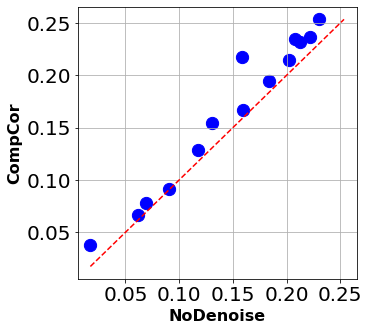

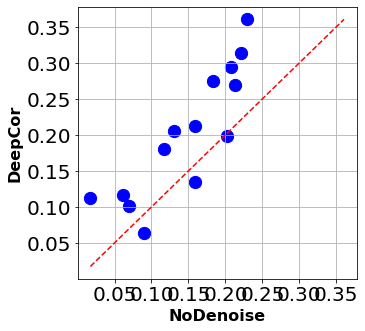

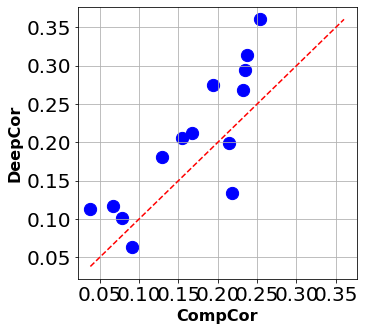

In [23]:
plt.figure(figsize=(5,5))
#plt.subplot(1,3,1);
plot_scatter(vec_ffa,vec_compcor,xlabel='NoDenoise',ylabel='CompCor',title='')
#plt.subplot(1,3,2);
plt.figure(figsize=(5,5))
plot_scatter(vec_ffa,vec_deepcor,xlabel='NoDenoise',ylabel='DeepCor',title='')
#plt.subplot(1,3,3);
plt.figure(figsize=(5,5))
plot_scatter(vec_compcor,vec_deepcor,xlabel='CompCor',ylabel='DeepCor',title='')

In [24]:
def pretty_bar_plot(arrs,group_labels,bar_color,title=''):
    # Organize data into a list for easy looping
    #arrs = [face_preproc_vals, face_compcor_vals, face_signal_vals]
    #group_labels = ['Face Preproc', 'Face CompCor', 'Face Signal']

    # Calculate means and standard deviations
    means = np.array([arr.mean() for arr in arrs])
    stds = np.array([arr.std() for arr in arrs])
    stds = stds / np.sqrt(len(arrs[0]))
    xs = np.arange(len(arrs))  # positions for each bar

    # Set the desired color for the bars (change this variable as needed)
    #bar_color = 'red'  # e.g., 'red', 'blue', 'green', etc.

    # Create the figure with appropriate dimensions for publication
    #plt.figure(figsize=(8, 6))

    # Plot bars with error bars
    bar_container = plt.bar(xs, means, yerr=stds, capsize=5,
                            color=bar_color, edgecolor='black', alpha=0.5)

    # Increase font sizes and set text bold for clarity in print.
    plt.xticks(xs, group_labels, fontsize=16, fontweight='bold')
    #plt.xlabel('Processing Type', fontsize=18, fontweight='bold')
    plt.ylabel('Corr. with Regressor', fontsize=18, fontweight='bold')
    #plt.title('Comparison of Face Processing Methods', fontsize=20, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Optionally, remove top and right borders for a clean aesthetic.
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Bold tick labels on the y-axis as well.
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
        label.set_fontweight('bold')

    plt.title(title,fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [25]:
face_preproc_vals = corr_res.mean(axis=1)[:,0]
face_compcor_vals = corr_res.mean(axis=1)[:,1]
face_signal_vals = corr_res.mean(axis=1)[:,2]

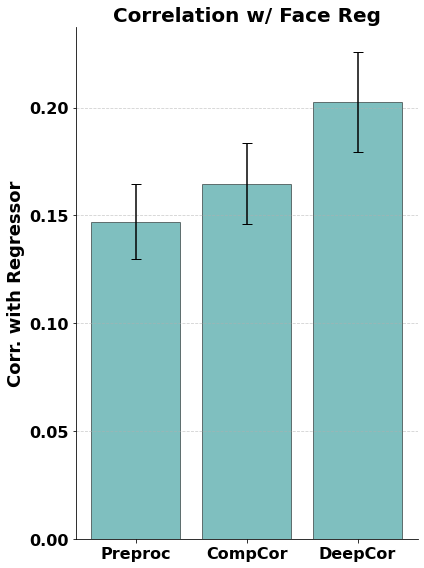

In [26]:
arrs = [face_preproc_vals,face_compcor_vals,face_signal_vals]
group_labels = ['Preproc','CompCor','DeepCor']
bar_color = 'teal'
plt.figure(figsize=(6,8))
pretty_bar_plot(arrs,group_labels,bar_color,title='Correlation w/ Face Reg')

In [27]:
def get_contrast_val(Y,return_type='contrast'):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn_temp.format(sub=subs[s],r=r),delimiter='\t')

    t_r = 2.0 
    n_scans = 156  # the acquisition comprises 128 scans
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    
    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values

    #['body', 'face', 'house', 'object', 'scene', 'scramble', 'drift_1','drift_2', 'drift_3', 'constant']
    
    #contrast_vector = np.array([2,2,-1,-1,-1,-1,0,0,0,0]) # Faces + Bodies > Rest
    contrast_vector = np.array([-1,5,-1,-1,-1,-1,0,0,0,0]) # Faces > Rest
    #contrast_vector = np.array([0,4,-1,-1,-1,-1,0,0,0,0]) # Faces > Rest
    contrast_values = beta @ contrast_vector
    if return_type=='contrast':
        return contrast_values.mean()
    elif return_type=='betas':
        return beta.mean(axis=0)

In [28]:
contrast_res = []
for s in range(nsubs):
    temp = []
    for r in [1,2,3,4]:
        vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg = get_sub_data(s,r,return_type
                                                                                    ='vals')
        temp.append([get_contrast_val(val) for val in [vals_ffa,vals_compcor,vals_signals_med]])
    contrast_res.append(temp)
contrast_res = np.array(contrast_res)

In [29]:
beta_res = []
for s in range(nsubs):
    temp = []
    for r in [1,2,3,4]:
        vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg = get_sub_data(s,r,return_type='vals')
        temp.append([get_contrast_val(val,return_type='betas') for val in [vals_ffa,vals_compcor,vals_signals_med]])
    beta_res.append(temp)
beta_res = np.array(beta_res)
beta_res.shape

(14, 4, 3, 10)

In [30]:
beta_res_avg = beta_res.mean(axis=1)
beta_res_avg.shape

(14, 3, 10)

In [31]:
contrast_res_avg = contrast_res.mean(axis=1)

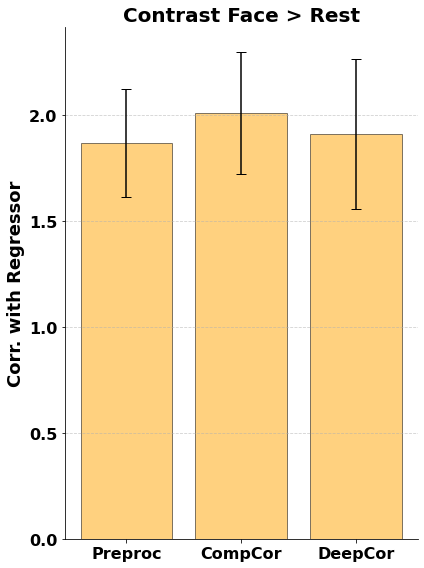

In [32]:
arrs = [contrast_res_avg[:,0],contrast_res_avg[:,1],contrast_res_avg[:,2]]
group_labels = ['Preproc','CompCor','DeepCor']
bar_color = 'orange'
plt.figure(figsize=(6,8))
pretty_bar_plot(arrs,group_labels,bar_color,title='Contrast Face > Rest')

In [33]:
pretty_t_test(contrast_res_avg[:,1],contrast_res_avg[:,0],'Contrast: CompCor > NoDenoise: ')
pretty_t_test(contrast_res_avg[:,2],contrast_res_avg[:,0],'Contrast: DeepCor > NoDenoise: ')
pretty_t_test(contrast_res_avg[:,2],contrast_res_avg[:,1],'Contrast: DeepCor > CompCor: ')

Contrast: CompCor > NoDenoise:  ΔM=0.14, t(13) = nan, p = nan
Contrast: DeepCor > NoDenoise:  ΔM=0.04, t(13) = nan, p = nan
Contrast: DeepCor > CompCor:  ΔM=-0.10, t(13) = nan, p = nan


<ipython-input-16-58ef47be35d7>:6: RuntimeWarning: invalid value encountered in arctanh
  t,p = ttest_rel(np.arctanh(vec1),np.arctanh(vec2),alternative=alternative)


In [34]:
d1=contrast_res_avg[:,1].mean()-contrast_res_avg[:,0].mean()
d2=contrast_res_avg[:,2].mean()-contrast_res_avg[:,1].mean()
print(d1)
print(d2)

0.14241075561048655
-0.09795909650194612


In [35]:
print(f'Face selectivity improvement: {d2/d1:.2f}x')

Face selectivity improvement: -0.69x


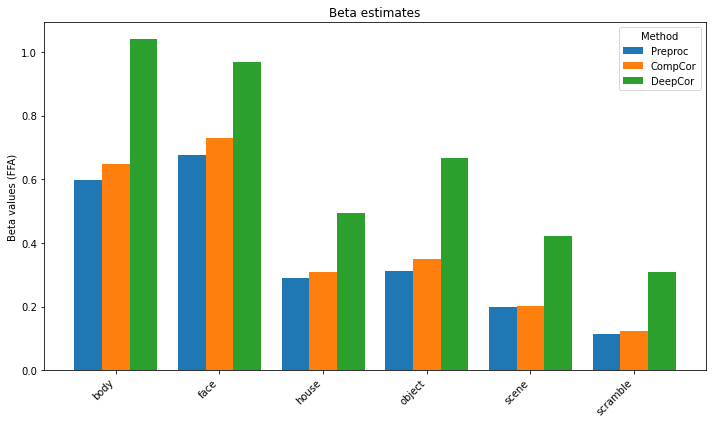

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# replace with your actual (14, 3, 10) array
input_arr = beta_res_avg

# mean over the first axis → shape (3, 10)
mean_vals = input_arr.mean(axis=0)

# labels
categories = ['Preproc', 'CompCor', 'DeepCor']
groups     = ['body', 'face', 'house', 'object', 'scene',
              'scramble', 'drift_1', 'drift_2', 'drift_3', 'constant']

mean_vals = mean_vals[:,0:6]
groups = groups[0:6]

n_groups, n_methods = len(groups), len(categories)
x = np.arange(n_groups)           # the label locations
width = 0.8 / n_methods           # total width of each group divided by # methods

fig, ax = plt.subplots(figsize=(10, 6))

# plot each method shifted by its index
for i, (cat, vals) in enumerate(zip(categories, mean_vals)):
    ax.bar(x + (i - (n_methods-1)/2) * width, vals, width, label=cat)

# formatting
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('Beta values (FFA)')
ax.set_title('Beta estimates')
ax.legend(title='Method')

plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def pretty_bar_plot(
    means=[4.2, 5.0, 8.9],
    sems=[0.9, 1.0, 1.3],
    bar_colors=['#003f5c', '#003f5c', '#00bcd4'],
    bar_edge_thickness=2.5,
    errorbar_thickness=3.5,
    tick_fontsize=20,
    tick_fontweight='bold',
    label_fontsize=22,
    y_max=None,
    significance_bars=[((0, 1), '*'), ((0, 2), '*'), ((1, 2), '*')],
    x_labels=['None', 'CompCor', 'DeepCor'],
    bar_spacing=1.2
):
    """
    Generate a high-quality bar plot with large fonts, thick lines, and spaced bars.

    Parameters:
        means, sems: List of means and standard errors.
        bar_colors: List of bar fill colors.
        bar_edge_thickness: Thickness of bar outline.
        errorbar_thickness: Thickness of error bars.
        tick_fontsize, tick_fontweight: Tick label styling.
        label_fontsize: Font size for axis labels.
        y_max: Optional y-axis limit.
        significance_bars: List of tuples ((bar1, bar2), marker).
        x_labels: Labels for each bar.
        bar_spacing: Distance between bars (default = 1.2).
    """
    n_bars = len(means)
    xs = np.arange(n_bars) * bar_spacing

    fig, ax = plt.subplots(figsize=(7, 9))

    # Bar plot with error bars
    ax.bar(xs, means, yerr=sems, capsize=10,
           color=bar_colors,
           edgecolor='black',
           linewidth=bar_edge_thickness,
           ecolor='black',
           error_kw=dict(linewidth=errorbar_thickness),
           zorder=2)

    # Axes and tick formatting
    ax.set_xticks(xs)
    ax.set_xticklabels(x_labels, fontsize=tick_fontsize, fontweight=tick_fontweight)
    ax.set_ylabel('Value', fontsize=label_fontsize, fontweight='bold')
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    for label in ax.get_yticklabels():
        label.set_fontweight(tick_fontweight)

    # Axis limit
    if y_max is None:
        y_max = max([m + s for m, s in zip(means, sems)]) + 3
    #ax.set_ylim(0, y_max)

    # Grid and frame aesthetics
    ax.yaxis.grid(True, linestyle='--', linewidth=1.5, alpha=0.4, zorder=1)
    for side in ['top', 'right']:
        ax.spines[side].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Significance markers
#     line_height = max([m + s for m, s in zip(means, sems)]) + 1
#     offset = 0.6  # vertical gap between significance bars
#     for i, ((x1_idx, x2_idx), marker) in enumerate(significance_bars):
#         x1, x2 = xs[x1_idx], xs[x2_idx]
#         y = line_height + i * offset
#         h = 0.3
#         ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black', lw=2.5)
#         ax.text((x1 + x2) / 2, y + h + 0.1, marker,
#                 ha='center', va='bottom',
#                 fontsize=24, fontweight='bold', color='black')

    plt.tight_layout()
    plt.show()

In [38]:
arrs = [vec_ffa,vec_compcor,vec_deepcor]

In [39]:
means = [arrs[0].mean(),arrs[1].mean(),arrs[2].mean()]
sems =[arrs[0].std(),arrs[1].std(),arrs[2].std()]
sems = np.array(sems) / np.sqrt(nsubs)

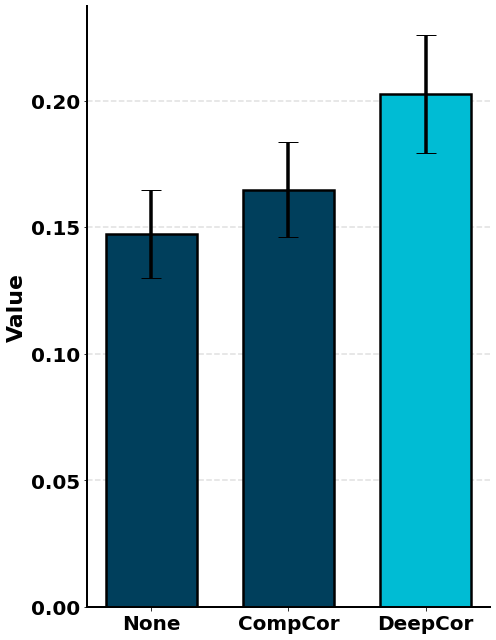

In [40]:
pretty_bar_plot(means,sems,
    significance_bars=[
        ((0, 1), '*'),  # B > A
        ((0, 2), '*'),  # C > A
        ((1, 2), '*')   # C > B
    ]
)

In [41]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [42]:
col_c_ffa = []
col_c_compcor = []
col_c_deepcor = []
col_vals_ffa = []
col_vals_compcor = []
col_vals_deepcor = []
for s in tqdm(range(nsubs)):
    for r in [1,2,3,4]:
        vals_ffa,vals_compcor,vals_signals_med,vals_signals,face_reg = get_sub_data(s,r,return_type='vals')
        c_ffa = correlate_columns(vals_ffa.transpose(),np.array([face_reg for _ in range(vals_ffa.shape[0])]).transpose())
        c_compcor = correlate_columns(vals_compcor.transpose(),np.array([face_reg for _ in range(vals_ffa.shape[0])]).transpose())
        c_deepcor = correlate_columns(vals_signals_med.transpose(),np.array([face_reg for _ in range(vals_ffa.shape[0])]).transpose())

        col_c_ffa.append(c_ffa)
        col_c_compcor.append(c_compcor)
        col_c_deepcor.append(c_deepcor)
        col_vals_ffa.append(vals_ffa)
        col_vals_compcor.append(vals_compcor)
        col_vals_deepcor.append(vals_signals_med)
        
col_c_ffa = np.hstack(col_c_ffa)
col_c_compcor = np.hstack(col_c_compcor)
col_c_deepcor = np.hstack(col_c_deepcor)
col_vals_ffa = np.concatenate(col_vals_ffa,axis=0)
col_vals_compcor = np.concatenate(col_vals_compcor,axis=0)
col_vals_deepcor = np.concatenate(col_vals_deepcor,axis=0)

100%|██████████| 14/14 [00:03<00:00,  3.91it/s]


In [43]:
diff=col_c_deepcor

In [44]:
diff.shape

(4416,)

In [45]:
I = np.argsort(diff)[::-1]

In [46]:
# for i. in
# for arr in [col_vals_ffa[i,:],col_vals_compcor[i,:],col_vals_deepcor[i,:]]:
#     plt.figure(figsize=(10,5))
#     plt.plot(arr,linewidth=3)
#     plt.plot(face_reg,linewidth=3)
#     plt.xticks(fontsize=20);
#     plt.yticks(fontsize=20);
#     plt.ylim(-3,4)

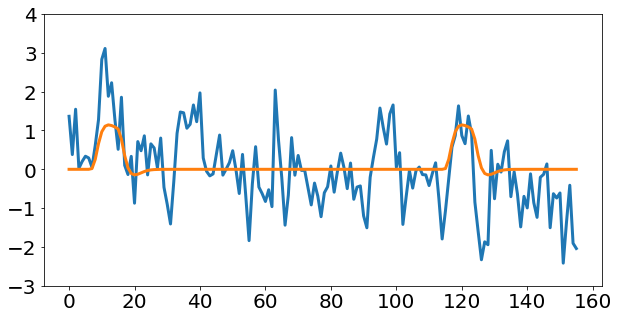

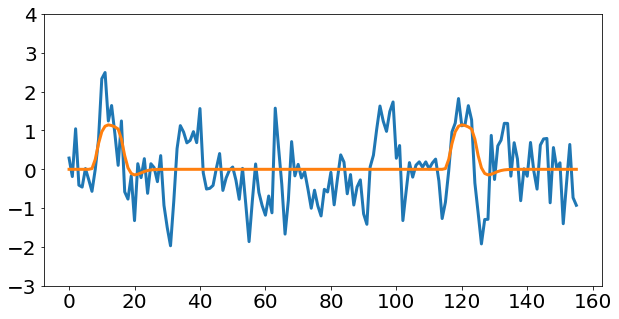

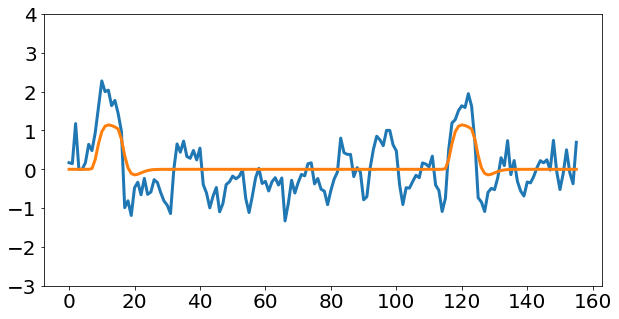

In [48]:
i = I[10]
for arr in [col_vals_ffa[i,:],col_vals_compcor[i,:],col_vals_deepcor[i,:]]:
    plt.figure(figsize=(10,5))
    plt.plot(arr,linewidth=3)
    plt.plot(face_reg,linewidth=3)
    plt.xticks(fontsize=20);
    plt.yticks(fontsize=20);
    plt.ylim(-3,4)

In [ ]:
#np.argwhere(np.array(body_reg)>.001)

In [ ]:
face_reg = [0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.2376563570021928e-38,
 0.01913035198215261,
 0.2551052154855983,
 0.6628580671786313,
 0.9680486516695602,
 1.1097390459193301,
 1.1447132947352492,
 1.1274394230021638,
 1.0917648905972168,
 1.0377679087359346,
 0.7759961551030653,
 0.3523588261787805,
 0.03868007611840972,
 -0.1070496808264999,
 -0.143767707381592,
 -0.12718642827190266,
 -0.09176489059721683,
 -0.05689826071808708,
 -0.031101370588663503,
 -0.015216893357411802,
 -0.006728727787969841,
 -0.002689365092830116,
 -0.000945587353657215,
 -0.0002529947302610424,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.950625428010361e-38,
 0.01913035198215354,
 0.2551052154856023,
 0.6628580671786409,
 0.9680486516695656,
 1.1097390459193321,
 1.1447132947352492,
 1.127439423002163,
 1.091764890597216,
 1.0377679087359317,
 0.7759961551030554,
 0.3523588261787706,
 0.03868007611840421,
 -0.10704968082650188,
 -0.14376770738159206,
 -0.12718642827190202,
 -0.09176489059721603,
 -0.05689826071808643,
 -0.031101370588663066,
 -0.015216893357411554,
 -0.006728727787969718,
 -0.0026893650928300605,
 -0.0009455873536571923,
 -0.00025299473026103376,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

body_reg = [0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.4753127140035906e-38,
 0.01913035198215292,
 0.2551052154855996,
 0.6628580671786327,
 0.968048651669561,
 1.1097390459193304,
 1.1447132947352492,
 1.1274394230021636,
 1.0917648905972168,
 1.0377679087359342,
 0.775996155103064,
 0.35235882617877906,
 0.03868007611840893,
 -0.10704968082650018,
 -0.14376770738159203,
 -0.12718642827190266,
 -0.09176489059721683,
 -0.05689826071808708,
 -0.031101370588663503,
 -0.015216893357411802,
 -0.006728727787969841,
 -0.002689365092830116,
 -0.000945587353657215,
 -0.0002529947302610395,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.950625428010361e-38,
 0.01913035198215354,
 0.2551052154856023,
 0.6628580671786354,
 0.9680486516695626,
 1.109739045919331,
 1.1447132947352492,
 1.1274394230021634,
 1.0917648905972166,
 1.0377679087359333,
 0.7759961551030611,
 0.35235882617877623,
 0.038680076118407354,
 -0.10704968082650075,
 -0.14376770738159203,
 -0.12718642827190244,
 -0.09176489059721657,
 -0.05689826071808687,
 -0.031101370588663357,
 -0.015216893357411719,
 -0.006728727787969799,
 -0.0026893650928300973,
 -0.0009455873536572075,
 -0.0002529947302610395,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]